## Análise de interação de variáveis com outras variáveis ou comportamentos acoplados de variáveis

## 00.Pacotes


In [ ]:
import pandas as pd
import numpy as np
import random
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

import funcoes_basicas as funcs
import funcoes_derivadas as funcs_deriv
from tqdm.notebook import tqdm
from tqdm import tqdm

# Definindo a semente
random.seed(123)

import warnings
warnings.filterwarnings("ignore")

C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 01. Baixando a base
- Realizando a separação em dados de treino e teste, marcando cada período na base final

In [ ]:
# Baixando os dados de treino
df_treino_full = pd.read_parquet(r'D:\projeto_modelo_credito\dados\base_treino_final.parquet\base_treino_final.parquet',
                                 engine='pyarrow')
df_treino_full.head()

,SK_ID_CURR,TARGET_publico,NAME_CONTRACT_TYPE_publico,CODE_GENDER_publico,FLAG_OWN_CAR_publico,FLAG_OWN_REALTY_publico,CNT_CHILDREN_publico,AMT_INCOME_TOTAL_publico,AMT_CREDIT_publico,AMT_ANNUITY_publico,...,VL_MAX_QTD_STATUS_X_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_X_ULTIMOS_36_MESES_externo,VL_TOT_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MED_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MAX_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_TOT_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MED_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MAX_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_1_ULTIMOS_36_MESES_externo
0,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,35.0,0.0,35.0,17.50,35.0,0.0,35.0,17.50,35.0,0.0
1,100263,0,Cash loans,F,N,Y,0,108000.0,585000.0,32665.5,...,5.0,0.0,79.0,19.75,5.0,0.0,79.0,19.75,5.0,0.0
2,100320,0,Cash loans,M,Y,Y,0,225000.0,481855.5,49374.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100704,0,Cash loans,F,N,N,0,90000.0,760500.0,22234.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100768,0,Cash loans,M,Y,N,0,112500.0,277969.5,10606.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Tirando a coluna CODE_GENDER_publico, não pode ser usada em modelos de risco de crédito
df_treino_full.drop('CODE_GENDER_publico', axis=1, inplace=True)

In [ ]:
# Convertendo o target para numérico
df_treino_full['TARGET_publico'] = df_treino_full['TARGET_publico'].astype(int)

# Separando features, target e ID
X = df_treino_full.drop(columns=['TARGET_publico'])
y = df_treino_full['TARGET_publico']
ids = df_treino_full['SK_ID_CURR']

# Separando treino e teste com estratificação
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Separando os IDs
id_train = X_train_full['SK_ID_CURR']
id_test = X_test_full['SK_ID_CURR']

# Removendo ID dos conjuntos de treino e teste para modelagem
X_train = X_train_full.drop(columns=['SK_ID_CURR'])
X_test = X_test_full.drop(columns=['SK_ID_CURR'])


In [ ]:
# Criando os DataFrames de cada grupo
df_treino_ids = pd.DataFrame({
    'SK_ID_CURR': id_train,
    'periodo': 'treino'
})

df_teste_ids = pd.DataFrame({
    'SK_ID_CURR': id_test,
    'periodo': 'teste'
})

# Concatenando os dois
df_periodo = pd.concat([df_treino_ids, df_teste_ids], ignore_index=True)

# Adicionando a coluna 'periodo' ao df_treino_full
df_treino_full_marcado = df_treino_full.merge(df_periodo, on='SK_ID_CURR', how='left')

In [ ]:
df_treino_full_marcado.head()

,SK_ID_CURR,TARGET_publico,NAME_CONTRACT_TYPE_publico,FLAG_OWN_CAR_publico,FLAG_OWN_REALTY_publico,CNT_CHILDREN_publico,AMT_INCOME_TOTAL_publico,AMT_CREDIT_publico,AMT_ANNUITY_publico,AMT_GOODS_PRICE_publico,...,VL_MIN_QTD_STATUS_X_ULTIMOS_36_MESES_externo,VL_TOT_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MED_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MAX_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_TOT_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MED_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MAX_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_1_ULTIMOS_36_MESES_externo,periodo
0,100010,0,Cash loans,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0.0,35.0,17.50,35.0,0.0,35.0,17.50,35.0,0.0,treino
1,100263,0,Cash loans,N,Y,0,108000.0,585000.0,32665.5,585000.0,...,0.0,79.0,19.75,5.0,0.0,79.0,19.75,5.0,0.0,treino
2,100320,0,Cash loans,Y,Y,0,225000.0,481855.5,49374.0,463500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,treino
3,100704,0,Cash loans,N,N,0,90000.0,760500.0,22234.5,760500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,treino
4,100768,0,Cash loans,Y,N,0,112500.0,277969.5,10606.5,229500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,treino


In [ ]:
df_treino_full_marcado.shape

(184350, 965)

In [ ]:
# Verificando se base foi marcda corretamente
print(df_treino_full_marcado['periodo'].value_counts(dropna=False))

periodo
treino    147480
teste      36870
Name: count, dtype: int64


In [ ]:
# Separando o dataframe de treino
df_treino = df_treino_full_marcado[df_treino_full_marcado['periodo'] == 'treino'].drop(columns=['periodo']).reset_index(drop=True).copy()
df_treino.head()

,SK_ID_CURR,TARGET_publico,NAME_CONTRACT_TYPE_publico,FLAG_OWN_CAR_publico,FLAG_OWN_REALTY_publico,CNT_CHILDREN_publico,AMT_INCOME_TOTAL_publico,AMT_CREDIT_publico,AMT_ANNUITY_publico,AMT_GOODS_PRICE_publico,...,VL_MAX_QTD_STATUS_X_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_X_ULTIMOS_36_MESES_externo,VL_TOT_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MED_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MAX_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_5_ULTIMOS_36_MESES_externo,VL_TOT_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MED_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MAX_QTD_STATUS_1_ULTIMOS_36_MESES_externo,VL_MIN_QTD_STATUS_1_ULTIMOS_36_MESES_externo
0,100010,0,Cash loans,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,35.0,0.0,35.0,17.50,35.0,0.0,35.0,17.50,35.0,0.0
1,100263,0,Cash loans,N,Y,0,108000.0,585000.0,32665.5,585000.0,...,5.0,0.0,79.0,19.75,5.0,0.0,79.0,19.75,5.0,0.0
2,100320,0,Cash loans,Y,Y,0,225000.0,481855.5,49374.0,463500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100704,0,Cash loans,N,N,0,90000.0,760500.0,22234.5,760500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100768,0,Cash loans,Y,N,0,112500.0,277969.5,10606.5,229500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_treino.shape

(147480, 964)

In [ ]:
df_treino.columns.to_list()

['SK_ID_CURR',
 'TARGET_publico',
 'NAME_CONTRACT_TYPE_publico',
 'FLAG_OWN_CAR_publico',
 'FLAG_OWN_REALTY_publico',
 'CNT_CHILDREN_publico',
 'AMT_INCOME_TOTAL_publico',
 'AMT_CREDIT_publico',
 'AMT_ANNUITY_publico',
 'AMT_GOODS_PRICE_publico',
 'NAME_TYPE_SUITE_publico',
 'NAME_INCOME_TYPE_publico',
 'NAME_EDUCATION_TYPE_publico',
 'NAME_FAMILY_STATUS_publico',
 'NAME_HOUSING_TYPE_publico',
 'REGION_POPULATION_RELATIVE_publico',
 'DAYS_BIRTH_publico',
 'DAYS_EMPLOYED_publico',
 'DAYS_REGISTRATION_publico',
 'DAYS_ID_PUBLISH_publico',
 'OWN_CAR_AGE_publico',
 'FLAG_MOBIL_publico',
 'FLAG_EMP_PHONE_publico',
 'FLAG_WORK_PHONE_publico',
 'FLAG_CONT_MOBILE_publico',
 'FLAG_PHONE_publico',
 'FLAG_EMAIL_publico',
 'OCCUPATION_TYPE_publico',
 'CNT_FAM_MEMBERS_publico',
 'REGION_RATING_CLIENT_publico',
 'REGION_RATING_CLIENT_W_CITY_publico',
 'WEEKDAY_APPR_PROCESS_START_publico',
 'HOUR_APPR_PROCESS_START_publico',
 'REG_REGION_NOT_LIVE_REGION_publico',
 'REG_REGION_NOT_WORK_REGION_publico'

In [ ]:
df = df_treino[[
    'SK_ID_CURR',
    'TARGET_publico',
    'EXT_SOURCE_3_publico',
    'NAME_CONTRACT_TYPE_publico',
    'AMT_INCOME_TOTAL_publico',
    'PAYMENT_RATE_publico',
    'FLAG_OWN_CAR_publico',
    'FLAG_OWN_REALTY_publico',
    'AMT_GOODS_PRICE_publico'
]]
df.head()

,SK_ID_CURR,TARGET_publico,EXT_SOURCE_3_publico,NAME_CONTRACT_TYPE_publico,AMT_INCOME_TOTAL_publico,PAYMENT_RATE_publico,FLAG_OWN_CAR_publico,FLAG_OWN_REALTY_publico,AMT_GOODS_PRICE_publico
0,100010,0,0.5406544504453575,Cash loans,360000.0,0.03,Y,Y,1530000.0
1,100263,0,0.2707073872651806,Cash loans,108000.0,0.06,N,Y,585000.0
2,100320,0,None,Cash loans,225000.0,0.10,Y,Y,463500.0
3,100704,0,0.6212263380626669,Cash loans,90000.0,0.03,N,N,760500.0
4,100768,0,0.5567274263630174,Cash loans,112500.0,0.04,Y,N,229500.0


In [ ]:
df.shape

(147480, 9)

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147480 entries, 0 to 147479
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  147480 non-null  object 
 1   TARGET_publico              147480 non-null  int32  
 2   EXT_SOURCE_3_publico        137193 non-null  object 
 3   NAME_CONTRACT_TYPE_publico  147480 non-null  object 
 4   AMT_INCOME_TOTAL_publico    147480 non-null  object 
 5   PAYMENT_RATE_publico        147473 non-null  float64
 6   FLAG_OWN_CAR_publico        147480 non-null  object 
 7   FLAG_OWN_REALTY_publico     147480 non-null  object 
 8   AMT_GOODS_PRICE_publico     147343 non-null  object 
dtypes: float64(1), int32(1), object(7)
memory usage: 9.6+ MB


In [ ]:
# 1- Tratando as variáveis

# Função que otimiza os tipos das variáveis classificando-as do modo mais adequado

def otimiza_tipos(df):
    for col in df.columns:
        # Forçar conversão de colunas tipo 'object' para número, se possível
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                pass  # Mantém como objeto se não for possível converter

        if pd.api.types.is_integer_dtype(df[col]):
            if df[col].max() > np.iinfo(np.int32).max or df[col].min() < np.iinfo(np.int32).min:
                df[col] = df[col].astype('Int64')
            else:
                df[col] = df[col].astype('Int32')

        elif pd.api.types.is_float_dtype(df[col]):
            if df[col].max() > np.finfo(np.float32).max or df[col].min() < -np.finfo(np.float32).max:
                df[col] = df[col].astype('float64')  # Evita usar 'Float64' Pandas
            else:
                df[col] = df[col].astype('float32')

    return df

df_dados = otimiza_tipos(df)
print('Variáveis otimizadas!')

Variáveis otimizadas!


In [ ]:
#2- Separarnado as variáveis por tipo
# Separando as variáveis por tipo: categórica, numérica e algumas que possam ter erro
# tirando as 2 primeiras variáveis 'SK_ID_CURR' e 'TARGET_publico'

vars = df.columns[2:].tolist()

lista_vars_num = []
lista_vars_categ = []
lista_vars_erro = []

for var in vars:
    tipo_coluna = df[var].dtype
    if tipo_coluna.name in (['Int32', 'Int64', 'int32', 'int64', 'Float32', 'Float64', 'float32', 'float64']):
        lista_vars_num.append(var)
    elif tipo_coluna.name in (['object', 'string', 'category']):
        lista_vars_categ.append(var)
    else:
        lista_vars_erro.append(var)

print(f'lista_vars_num: {len(lista_vars_num)}')
print()
print(f'lista_vars_categ: {len(lista_vars_categ)}')
print()
print(f'lista_vars_erro: {len(lista_vars_erro)}')


lista_vars_num: 4

lista_vars_categ: 3

lista_vars_erro: 0


In [ ]:
## Substituindo pd.NA por np.nan

df = df.replace({pd.NA: np.nan})

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147480 entries, 0 to 147479
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  147480 non-null  Int32  
 1   TARGET_publico              147480 non-null  Int32  
 2   EXT_SOURCE_3_publico        137193 non-null  float32
 3   NAME_CONTRACT_TYPE_publico  147480 non-null  object 
 4   AMT_INCOME_TOTAL_publico    147480 non-null  float32
 5   PAYMENT_RATE_publico        147473 non-null  float32
 6   FLAG_OWN_CAR_publico        147480 non-null  object 
 7   FLAG_OWN_REALTY_publico     147480 non-null  object 
 8   AMT_GOODS_PRICE_publico     147343 non-null  float32
dtypes: Int32(2), float32(4), object(3)
memory usage: 7.0+ MB


In [ ]:
df.isna().sum()

SK_ID_CURR                        0
TARGET_publico                    0
EXT_SOURCE_3_publico          10287
NAME_CONTRACT_TYPE_publico        0
AMT_INCOME_TOTAL_publico          0
PAYMENT_RATE_publico              7
FLAG_OWN_CAR_publico              0
FLAG_OWN_REALTY_publico           0
AMT_GOODS_PRICE_publico         137
dtype: int64

In [ ]:
df = df.fillna(-999)

In [ ]:
df.isna().sum()

SK_ID_CURR                    0
TARGET_publico                0
EXT_SOURCE_3_publico          0
NAME_CONTRACT_TYPE_publico    0
AMT_INCOME_TOTAL_publico      0
PAYMENT_RATE_publico          0
FLAG_OWN_CAR_publico          0
FLAG_OWN_REALTY_publico       0
AMT_GOODS_PRICE_publico       0
dtype: int64

In [ ]:
# Trocando N e Y por 0 e 1, respectivamente, nas variáveis abaixo

df['FLAG_OWN_CAR_publico'] = df['FLAG_OWN_CAR_publico'].replace({'N': 0, 'Y':1})
df['FLAG_OWN_REALTY_publico'] = df['FLAG_OWN_REALTY_publico'].replace({'N': 0, 'Y': 1})

In [ ]:
df.head()

,SK_ID_CURR,TARGET_publico,EXT_SOURCE_3_publico,NAME_CONTRACT_TYPE_publico,AMT_INCOME_TOTAL_publico,PAYMENT_RATE_publico,FLAG_OWN_CAR_publico,FLAG_OWN_REALTY_publico,AMT_GOODS_PRICE_publico
0,100010,0,0.540654,Cash loans,360000.0,0.03,1,1,1530000.0
1,100263,0,0.270707,Cash loans,108000.0,0.06,0,1,585000.0
2,100320,0,-999.000000,Cash loans,225000.0,0.10,1,1,463500.0
3,100704,0,0.621226,Cash loans,90000.0,0.03,0,0,760500.0
4,100768,0,0.556727,Cash loans,112500.0,0.04,1,0,229500.0


### Variável: PAYMENT_RATE_publico'
- interação com a variável NAME_CONTRACT_TYPE_publico

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# Usando o qcut
df['fx_PAYMENT_RATE_publico'] = pd.qcut(df['PAYMENT_RATE_publico'], q=3, duplicates='drop')

df['fx_PAYMENT_RATE_publico'].value_counts()

fx_PAYMENT_RATE_publico
(-999.001, 0.04]    60224
(0.05, 0.12]        44997
(0.04, 0.05]        42259
Name: count, dtype: int64

In [ ]:
pd.crosstab(df['fx_PAYMENT_RATE_publico'], df['NAME_CONTRACT_TYPE_publico'])

NAME_CONTRACT_TYPE_publico,Cash loans,Revolving loans
fx_PAYMENT_RATE_publico,,
"(-999.001, 0.04]",60224,0
"(0.04, 0.05]",28274,13985
"(0.05, 0.12]",44977,20


In [ ]:
pd.crosstab(df['fx_PAYMENT_RATE_publico'], df['NAME_CONTRACT_TYPE_publico'], values=df['TARGET_publico'], aggfunc='mean', margins=True).round(4)*100

NAME_CONTRACT_TYPE_publico,Cash loans,Revolving loans,All
fx_PAYMENT_RATE_publico,,,
"(-999.001, 0.04]",6.1,<NA>,6.1
"(0.04, 0.05]",11.93,5.28,9.73
"(0.05, 0.12]",8.09,0.0,8.08
All,8.0,5.28,7.74


In [ ]:
# Gerar a crosstab com médias
tabela = pd.crosstab(
    df['fx_PAYMENT_RATE_publico'],
    df['NAME_CONTRACT_TYPE_publico'],
    values=df['TARGET_publico'],
    aggfunc='mean',
    margins=True
).round(4) * 100

# Função para pintar NaNs com fundo cinza claro
def cor_nulo(val):
    if pd.isnull(val):
        return 'background-color: lightgrey'
    return ''

# Aplicar o gradiente e pintar os NaNs
styled = (
    tabela.style
    .background_gradient(cmap='Reds', axis=None)
    .applymap(cor_nulo)
)

display(styled)

NAME_CONTRACT_TYPE_publico,Cash loans,Revolving loans,All
fx_PAYMENT_RATE_publico,,,
"(-999.001, 0.04]",6.100000,,6.100000
"(0.04, 0.05]",11.930000,5.280000,9.730000
"(0.05, 0.12]",8.090000,0.000000,8.080000
All,8.000000,5.280000,7.740000


In [ ]:
df['fx_PAYMENT_RATE_publico'] = pd.cut(df['PAYMENT_RATE_publico'],[-np.inf, 0.0399, 0.05, 0.055, np.inf], include_lowest=True)

df['fx_PAYMENT_RATE_publico'].value_counts()

fx_PAYMENT_RATE_publico
(0.055, inf]      44997
(0.05, 0.055]     42259
(-inf, 0.0399]    33211
(0.0399, 0.05]    27013
Name: count, dtype: int64

In [ ]:
pd.crosstab(df['fx_PAYMENT_RATE_publico'], df['NAME_CONTRACT_TYPE_publico'])

NAME_CONTRACT_TYPE_publico,Cash loans,Revolving loans
fx_PAYMENT_RATE_publico,,
"(-inf, 0.0399]",33211,0
"(0.0399, 0.05]",27013,0
"(0.05, 0.055]",28274,13985
"(0.055, inf]",44977,20


In [ ]:
pd.crosstab(df['fx_PAYMENT_RATE_publico'], df['NAME_CONTRACT_TYPE_publico'], values=df['TARGET_publico'], aggfunc='mean', margins=True).round(4)*100

NAME_CONTRACT_TYPE_publico,Cash loans,Revolving loans,All
fx_PAYMENT_RATE_publico,,,
"(-inf, 0.0399]",6.12,<NA>,6.12
"(0.0399, 0.05]",6.07,<NA>,6.07
"(0.05, 0.055]",11.93,5.28,9.73
"(0.055, inf]",8.09,0.0,8.08
All,8.0,5.28,7.74


In [ ]:
# Gerar a crosstab com médias
tabela = pd.crosstab(
    df['fx_PAYMENT_RATE_publico'],
    df['NAME_CONTRACT_TYPE_publico'],
    values=df['TARGET_publico'],
    aggfunc='mean',
    margins=True
).round(4) * 100

# Função para pintar NaNs com fundo cinza claro
def cor_nulo(val):
    if pd.isnull(val):
        return 'background-color: lightgrey'
    return ''

# Aplicar o gradiente e pintar os NaNs
styled = (
    tabela.style
    .background_gradient(cmap='Reds', axis=None)
    .applymap(cor_nulo)
)

display(styled)

NAME_CONTRACT_TYPE_publico,Cash loans,Revolving loans,All
fx_PAYMENT_RATE_publico,,,
"(-inf, 0.0399]",6.120000,,6.120000
"(0.0399, 0.05]",6.070000,,6.070000
"(0.05, 0.055]",11.930000,5.280000,9.730000
"(0.055, inf]",8.090000,0.000000,8.080000
All,8.000000,5.280000,7.740000


### Variável: AMT_INCOME_TOTAL_publico

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# Usando o qcut
df['fx_AMT_GOODS_PRICE_publico'] = pd.qcut(df['AMT_GOODS_PRICE_publico'], q=4, duplicates='drop')

df['fx_AMT_GOODS_PRICE_publico'].value_counts()

fx_AMT_GOODS_PRICE_publico
(-999.001, 238500.0]     37391
(238500.0, 450000.0]     37203
(450000.0, 688500.0]     36878
(688500.0, 4050000.0]    36008
Name: count, dtype: int64

In [ ]:
# FLAG_OWN_REALTY_publico, FLAG_OWN_CAR_publico

pd.crosstab(df['fx_AMT_GOODS_PRICE_publico'], df['FLAG_OWN_REALTY_publico'])

FLAG_OWN_REALTY_publico,0,1
fx_AMT_GOODS_PRICE_publico,,
"(-999.001, 238500.0]",10558,26833
"(238500.0, 450000.0]",11797,25406
"(450000.0, 688500.0]",11467,25411
"(688500.0, 4050000.0]",11713,24295


In [ ]:
# Criando um nova variável como combinação

df['nova_flag'] = np.where(
    (df['FLAG_OWN_REALTY_publico'] == 0) & (df['FLAG_OWN_CAR_publico'] == 0), 0,
    np.where(
        (df['FLAG_OWN_REALTY_publico'] == 1) & (df['FLAG_OWN_CAR_publico'] == 1), 1,
        np.where(
            (df['FLAG_OWN_REALTY_publico'] == 1) & (df['FLAG_OWN_CAR_publico'] == 0), 2,
            np.where(
                (df['FLAG_OWN_REALTY_publico'] == 0) & (df['FLAG_OWN_CAR_publico'] == 1), 3,
                     np.nan
                    )
                )
            )
        )

df.head()

,SK_ID_CURR,TARGET_publico,EXT_SOURCE_3_publico,NAME_CONTRACT_TYPE_publico,AMT_INCOME_TOTAL_publico,PAYMENT_RATE_publico,FLAG_OWN_CAR_publico,FLAG_OWN_REALTY_publico,AMT_GOODS_PRICE_publico,fx_PAYMENT_RATE_publico,fx_AMT_GOODS_PRICE_publico,nova_flag
0,100010,0,0.540654,Cash loans,360000.0,0.03,1,1,1530000.0,"(-inf, 0.0399]","(688500.0, 4050000.0]",1.0
1,100263,0,0.270707,Cash loans,108000.0,0.06,0,1,585000.0,"(0.055, inf]","(450000.0, 688500.0]",2.0
2,100320,0,-999.000000,Cash loans,225000.0,0.10,1,1,463500.0,"(0.055, inf]","(450000.0, 688500.0]",1.0
3,100704,0,0.621226,Cash loans,90000.0,0.03,0,0,760500.0,"(-inf, 0.0399]","(688500.0, 4050000.0]",0.0
4,100768,0,0.556727,Cash loans,112500.0,0.04,1,0,229500.0,"(0.0399, 0.05]","(-999.001, 238500.0]",3.0


-  nova variável terá valor 0 se as duas flags são zero, 1 se as duas flags forem iguais a 1, 2 se somente a FLAG_OWN_REALTY_publico =1, e 3 se FLAG_OWN_CAR_publico = 1

In [ ]:
# FLAG_OWN_REALTY_publico, FLAG_OWN_CAR_publico

pd.crosstab(df['fx_AMT_GOODS_PRICE_publico'], df['nova_flag'])

nova_flag,0.0,1.0,2.0,3.0
fx_AMT_GOODS_PRICE_publico,,,,
"(-999.001, 238500.0]",7483,7479,19354,3075
"(238500.0, 450000.0]",7839,8943,16463,3958
"(450000.0, 688500.0]",7592,8471,16940,3875
"(688500.0, 4050000.0]",6531,10508,13787,5182


In [ ]:
pd.crosstab( df['nova_flag'], df['TARGET_publico'], margins=True)

TARGET_publico,0,1,All
nova_flag,,,
0.0,26865,2580,29445
1.0,32905,2496,35401
2.0,61277,5267,66544
3.0,15012,1078,16090
All,136059,11421,147480


In [ ]:
pd.crosstab(df['fx_AMT_GOODS_PRICE_publico'], df['nova_flag'], values=df['TARGET_publico'], aggfunc='mean', margins=True).round(4)*100

nova_flag,0.0,1.0,2.0,3.0,All
fx_AMT_GOODS_PRICE_publico,,,,,
"(-999.001, 238500.0]",8.71,6.65,7.49,6.89,7.52
"(238500.0, 450000.0]",11.98,9.68,10.74,9.15,10.58
"(450000.0, 688500.0]",7.76,6.95,7.35,6.74,7.28
"(688500.0, 4050000.0]",6.12,5.18,5.83,4.69,5.53
All,8.76,7.05,7.92,6.7,7.74


In [ ]:
# Gerar a crosstab com médias
tabela = pd.crosstab(
    df['fx_AMT_GOODS_PRICE_publico'],
    df['nova_flag'],
    values=df['TARGET_publico'],
    aggfunc='mean',
    margins=True
).round(4) * 100

# Função para pintar NaNs com fundo cinza claro
def cor_nulo(val):
    if pd.isnull(val):
        return 'background-color: lightgrey'
    return ''

# Aplicar o gradiente e pintar os NaNs
styled = (
    tabela.style
    .background_gradient(cmap='Reds', axis=None)
    .applymap(cor_nulo)
)

display(styled)

nova_flag,0.000000,1.000000,2.000000,3.000000,All
fx_AMT_GOODS_PRICE_publico,,,,,
"(-999.001, 238500.0]",8.710000,6.650000,7.490000,6.890000,7.520000
"(238500.0, 450000.0]",11.980000,9.680000,10.740000,9.150000,10.580000
"(450000.0, 688500.0]",7.760000,6.950000,7.350000,6.740000,7.280000
"(688500.0, 4050000.0]",6.120000,5.180000,5.830000,4.690000,5.530000
All,8.760000,7.050000,7.920000,6.700000,7.740000


In [ ]:
# analisando a bad para cada caso

In [ ]:
# 0
2580/29445
#Bad 8.7%
# Qdo o cliente não tem nenhum bem durável ele é mais inadimplente

0.08762098828323994

In [ ]:
# 1
2496/35401
#Bad 7%

0.0705064828677156

In [ ]:
# 2
5267/66544
#Bad 7.9

0.07915063717239722

In [ ]:
1078/16090
#Bad 6.7%

0.06699813548788067

In [ ]:
df['nova_flag'].dtype

dtype('float64')

In [ ]:
df['anomes'] = 202504

In [ ]:
# Usando o cut
df['fx_nova_flag'] = pd.cut(df['nova_flag'], [-0.1,0,1,2,3], include_lowest=True)

df['fx_nova_flag'].value_counts()

fx_nova_flag
(1.0, 2.0]       66544
(0.0, 1.0]       35401
(-0.101, 0.0]    29445
(2.0, 3.0]       16090
Name: count, dtype: int64


📊 Variável categórica: fx_nova_flag


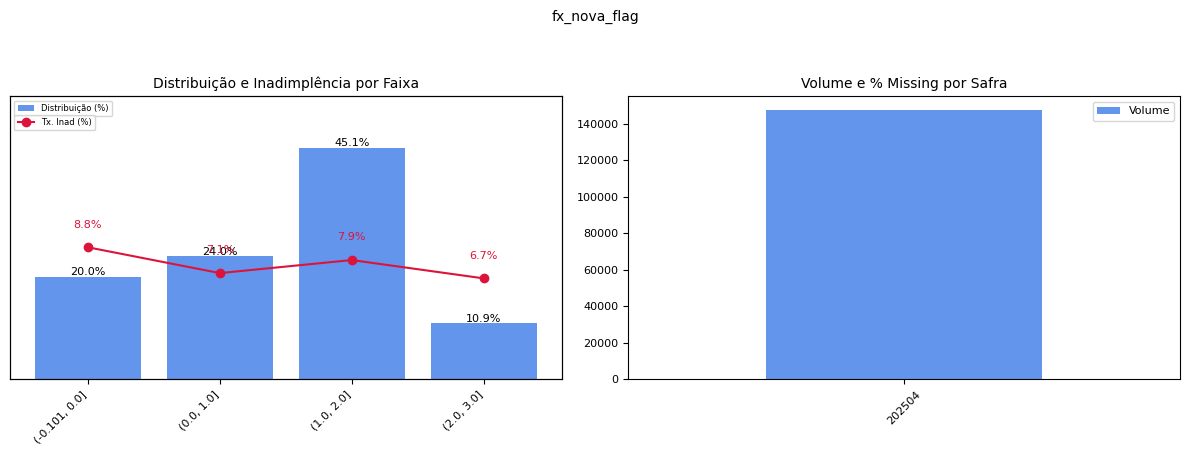

In [ ]:
funcs_deriv.graficos_combinados_categorica(
    df=df,
    lista_variaveis=[
        'fx_nova_flag'
    ],
    nome_target='TARGET_publico',
    nome_data='anomes'
)
